In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

<h1>Reading Data</h1>

In [81]:
headers = ["Age", "WorkClass", "FnlWgt", "Education", "EducationNum",
           "MaritalStatus", "Occupation", "Relationship",
          "Race", "Gender", "CapitalGain", "CapitalLoss", "HoursPerWeek", 
           "NativeCountry", "Income"]

In [82]:
train = pd.read_csv("../data/census-income.data", names = headers)
test = pd.read_csv("../data/census-income.test", skiprows = 1, names = headers)

In [83]:
train.head()

,Age,WorkClass,FnlWgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [84]:
test.head()

,Age,WorkClass,FnlWgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


<h1>Cleaning Data</h1>
<p>The Data contains extra spaces and dots and null values. Cleaning the data to remove these values.</p>

In [85]:
numerical = []
categorical = []

for header in headers:
    if train[header].dtype != np.dtype("int64"):
        categorical.append(header)
        train[header] = train[header].map(lambda x:x.strip(" "))
    else:
        numerical.append(header)

In [86]:
for header in headers:
    if test[header].dtype != np.dtype("int64"):
        test[header] = test[header].map(lambda x:x.strip(" "))

In [87]:
test["Income"] = test["Income"].map(lambda x:x.strip("."))

In [88]:
train = train.replace("?", np.nan)
test = test.replace("?", np.nan)

data = pd.concat([train, test], ignore_index = True)

dataMissing = data[data.isna().any(axis=1)]

In [89]:
# train.dropna(how = "any", inplace = True)
# test.dropna(how = "any", inplace = True)
data.dropna(how = "any", inplace = True)

<h1>Saving the cleaned data</h1>

In [90]:
# train.to_csv("../data/censusTrain.csv", index = False)
# test.to_csv("../data/censusTest.csv", index = False)
data.to_csv("../data/censusData.csv", index = False)
dataMissing.to_csv("../data/censusMissing.csv", index = False)

<h1>Loading the cleaned data</h1>

In [91]:
# train = pd.read_csv("../data/censusTrain.csv")
# test = pd.read_csv("../data/censusTest.csv")
data = pd.read_csv("../data/censusData.csv")
dataMissing = pd.read_csv("../data/censusMissing.csv")

<h1>Data Summary</h1>

In [92]:
def dataDescription(data):
    for column in data.columns:
        print(column)
        if data.dtypes[column] != np.dtype("int64"):
            print(data[column].value_counts())
        else:
            print(data[column].describe()) 
        print('\n')

In [93]:
dataDescription(data)

Age
count    45222.000000
mean        38.547941
std         13.217870
min         17.000000
25%         28.000000
50%         37.000000
75%         47.000000
max         90.000000
Name: Age, dtype: float64


WorkClass
Private             33307
Self-emp-not-inc     3796
Local-gov            3100
State-gov            1946
Self-emp-inc         1646
Federal-gov          1406
Without-pay            21
Name: WorkClass, dtype: int64


FnlWgt
count    4.522200e+04
mean     1.897347e+05
std      1.056392e+05
min      1.349200e+04
25%      1.173882e+05
50%      1.783160e+05
75%      2.379260e+05
max      1.490400e+06
Name: FnlWgt, dtype: float64


Education
HS-grad         14783
Some-college     9899
Bachelors        7570
Masters          2514
Assoc-voc        1959
11th             1619
Assoc-acdm       1507
10th             1223
7th-8th           823
Prof-school       785
9th               676
12th              577
Doctorate         544
5th-6th           449
1st-4th           222
Preschool     

<h1>Visualization</h1>

In [94]:
def visualizeCategoricalData(data, features, hue, size):
    plots = len(features)
    cols = 2
    rows = plots//cols

    fig, axs = plt.subplots(nrows = rows, ncols = cols, figsize = (size*cols, size*rows), constrained_layout = True)

    for position, category in enumerate(features):
        row = position // cols
        col = position % cols

        plot = sns.countplot(y = category, hue = hue, data = data, ax = axs[row][col])

In [95]:
def visualizeNumericalData(data, features):
    plt.figure(figsize = (10, 10))
    ax = sns.heatmap(data[features].corr(), annot = True, fmt='.1g', vmin = -1, vmax = 1, center = 0)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

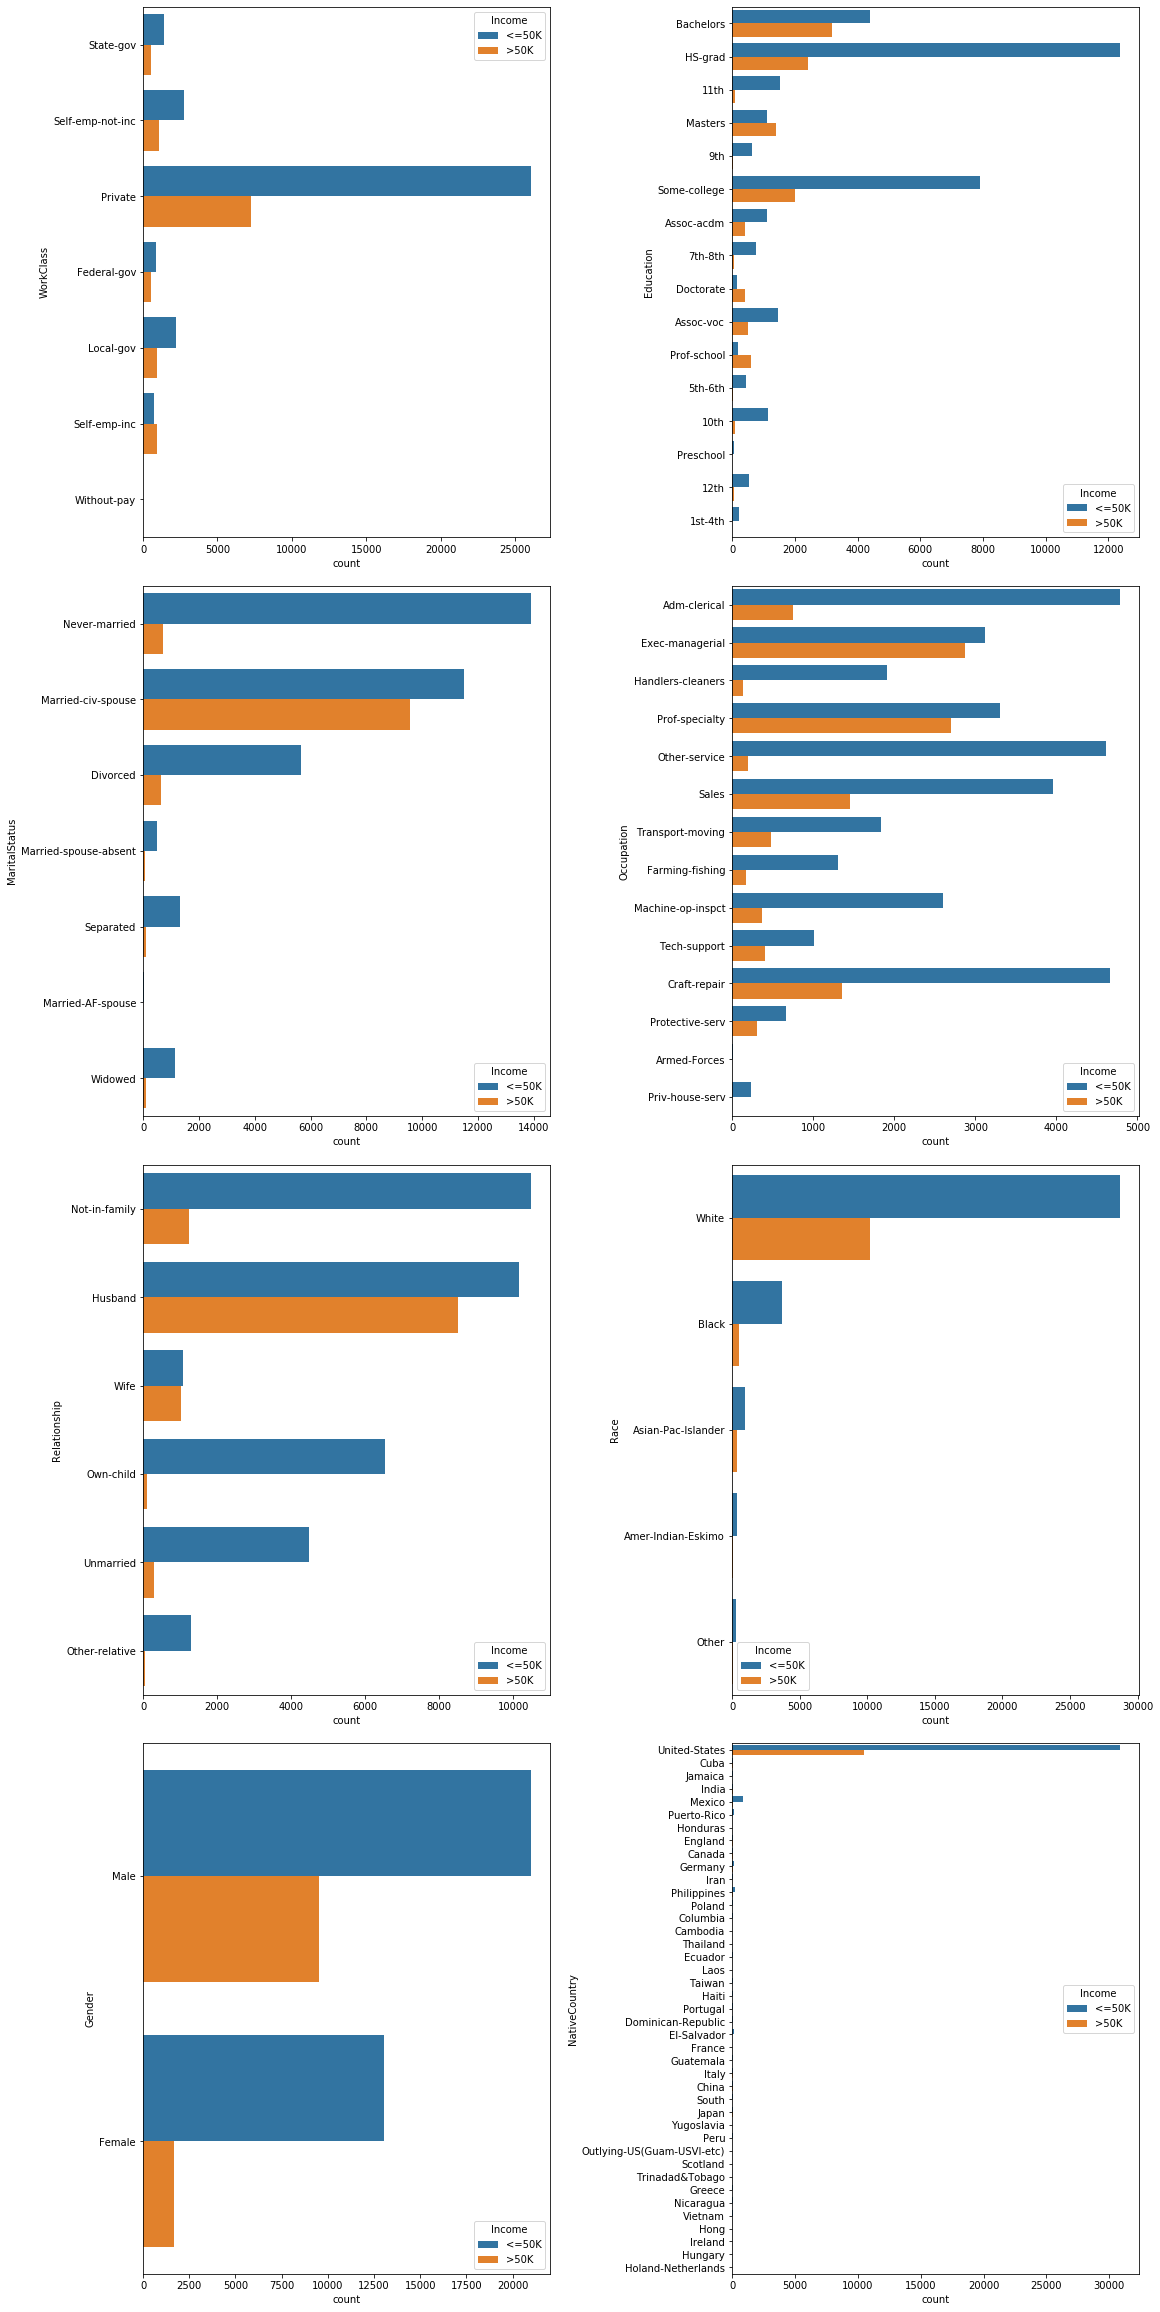

In [96]:
visualizeCategoricalData(data, categorical[:-1], "Income", 8)

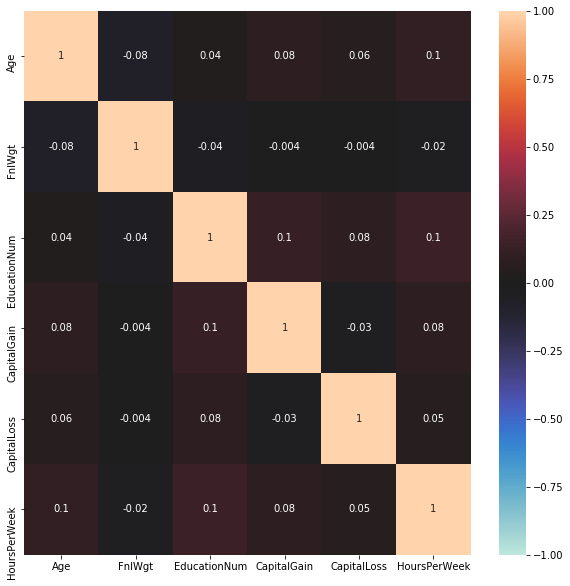

In [97]:
visualizeNumericalData(data, numerical)

<h1>Numerical Encoding of categorical Data</h1>

In [98]:
data[["Education", "EducationNum"]].head(15)

,Education,EducationNum
0,Bachelors,13
1,Bachelors,13
2,HS-grad,9
3,11th,7
4,Bachelors,13
5,Masters,14
6,9th,5
7,HS-grad,9
8,Masters,14
9,Bachelors,13


<p>As we can see above that, the columns Eduaction and EduactionNum are both the same, EduactionNum is the numerical encoding of Eduaction. So, we can drop one. It is ideal to drop Eduaction becuase while model numerical features like EduactionNum are required.</p>

In [99]:
educationMappings = data[["Education", "EducationNum"]].drop_duplicates()
data = data.drop(columns = ["Education"])
dataMissing = dataMissing.drop(columns = ["Education"])

In [100]:
educationMappings

,Education,EducationNum
0,Bachelors,13
2,HS-grad,9
3,11th,7
5,Masters,14
6,9th,5
10,Some-college,10
13,Assoc-acdm,12
14,7th-8th,4
19,Doctorate,16
45,Assoc-voc,11


<p>Similarly, we want to encode every other categorical feature into numerical. We cannot encode them in same way as the Education and EducationNum because the other feature are not all ordinal like these two. So, we can either proceed with one hot encoding.</p>

In [101]:
def categoricalToNumerical(data):
    for column in data.columns[:-1]:
        if data.dtypes[column] != np.dtype("int64"):
            data = data.join(pd.get_dummies(data[column])).drop(column, 1)
        else:
             data = data.drop(column, 1).join(data[column])
    data = data.drop("Income", 1).join(data["Income"])
    return data

In [102]:
data = categoricalToNumerical(data)
# test = categoricalToNumerical(test)
# test.insert(test.columns.get_loc("Haiti")+1, "Holand-Netherlands", 0)

In [103]:
incomeMapping = {"<=50K" : 0, ">50K" : 1}

In [104]:
data = data.replace("<=50K", 0).replace(">50K", 1)
dataMissing = dataMissing.replace("<=50K", 0).replace(">50K", 1)

In [105]:
dataList = data.values.tolist()

train = dataList[:40000]
test = dataList[40000:]

In [106]:
trainFeatures = []
trainY = []
for t in train:
    trainFeatures.append(t[:-1])
    trainY.append(t[-1])

In [107]:
testFeatures = []
testY = []
for t in test:
    testFeatures.append(t[:-1])
    testY.append(t[-1])

<h1>Modeling</h1>

<h1>Logistic Regression</h1>

In [108]:
def logisticRegression(x, y, alpha):
    x = np.array(x)
    y = np.array(y)
    weight = np.zeros(len(x[0]))
    for step in range(1000):
        weight = weight + (alpha * np.dot(x.T, y - predict(weight, x)))
    return weight

In [109]:
def predict(weights, features):
    return 1/(1 + np.exp(-1*(np.dot(features, weights))))

In [110]:
def error(weights, data):
    errors = [abs(data[1][i] - predict(weights, data[0][i]))for i in range(len(data[0]))]
    return sum(errors)/len(errors)

In [111]:
featuresTrain = [] 
featuresTest = []

for t in trainFeatures:
    featuresTrain.append([1] + t)

for t in testFeatures:
    featuresTest.append([1] + t)

In [112]:
weights = logisticRegression(featuresTrain, trainY, 0.05)

In [113]:
predict(weights, featuresTest[0])

0.0

In [114]:
error(weights, [featuresTest, testY])

0.21658368441210266

<h1>KNN</h1>

In [115]:
def euclideanDistance(a, b):
    distance = 0
    for i in range(len(a)):
        distance += (a[i] - b[i])**2
    return (distance)**0.5

In [116]:
def kNearestNeighbors(train, test, k):
    distance = []
    for t in train:
        distance.append((t[-1],euclideanDistance(t[:-1], test)))
    distance.sort(key=lambda x: x[1])
    # print("top k neighbours : ", distance[:k])
    return [distance[i][0] for i in range(k)]

In [117]:
def predict(train, test, k):
    neighbors = kNearestNeighbors(train, test, k)
    return max(Counter(neighbors).items(), key=lambda x: x[1])[0]

In [118]:
def error(train, features, y, k):
    errors = [abs(y[i] - predict(train, features[i], k))for i in range(len(features))]
    return sum(errors)/len(errors)

In [119]:
predict(trainList[1:], trainList[0][:-1], 2)

0

In [120]:
error(trainList, testFeatures[:100], testY[:100], 5)

0.28